# Análise da distribuição dos requisitos técnicos por localização e tipo da vaga

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Importando o grafo completo
G = nx.read_gexf("job_skill_graph.gexf")

In [3]:
# Analisando os tipos de nós
node_types = nx.get_node_attributes(G, "type")
print("Tipos de nós no grafo:", set(node_types.values()))

Tipos de nós no grafo: {'skill', 'job'}


## Filtrando a rede a partir dos atributos a serem analisados

In [4]:
def build_subgraph(G, filter_attr, filter_value):
    """
    Builds a subgraph of the input graph G, including nodes that are either of type 'skill' or have a specific attribute value.
    Args:
        G (networkx.Graph): The input graph.
        filter_attr (str): The node attribute to filter by.
        filter_value (str): The value of the attribute to filter nodes.
    Returns:
        networkx.Graph: The resulting subgraph.
    """
    nodes = [
        n
        for n, d in G.nodes(data=True)
        if (d.get("type") == "skill") or (d.get(filter_attr) == filter_value)
    ]

    subG = G.subgraph(nodes).copy()

    # Removendo skills isoladas
    isolated_skills = [
        n
        for n, d in subG.nodes(data=True)
        if (d.get("type") == "skill" and subG.degree(n) == 0)
    ]
    subG.remove_nodes_from(isolated_skills)

    print(
        f"Subgrafo ({filter_attr}={filter_value}): {len(subG.nodes())} nós e {len(subG.edges())} arestas (grau médio {np.mean([d for n, d in subG.degree()]) :.2f})"
    )

    return subG

In [5]:
subgraphs = {}

# Filtrando por região do país
locations = set(nx.get_node_attributes(G, "location").values())
for location in locations:
    # Ignorar 'Brazil' pois está relacionado a vagas remotas
    if location == "Brazil":
        continue

    subgraphs[f"location_{location}"] = build_subgraph(G, "location", location)

# Filtrando por remoto/não-remoto
for remote_status in [True, False]:
    subgraphs[f"remote_{remote_status}"] = build_subgraph(G, "remote", remote_status)

Subgrafo (location=Northeast): 3404 nós e 15436 arestas (grau médio 9.07)
Subgrafo (location=South): 7664 nós e 38512 arestas (grau médio 10.05)
Subgrafo (location=Central-West): 2554 nós e 11511 arestas (grau médio 9.01)
Subgrafo (location=Southeast): 30588 nós e 170591 arestas (grau médio 11.15)
Subgrafo (location=North): 1027 nós e 3747 arestas (grau médio 7.30)
Subgrafo (remote=True): 21456 nós e 155745 arestas (grau médio 14.52)
Subgrafo (remote=False): 35119 nós e 183936 arestas (grau médio 10.48)


## Analisando as subredes por métricas de centralidade

In [6]:
def normalize_feature(feature):
    """
    Normalizes a list or array of values to a range between 0 and 1 (min-max normalization).
    Args:
        feature (list or np.array): A list or array of feature values.
    Returns:
        np.array: An array of normalized feature values.
    """
    values_array = np.array(feature)
    min_val = values_array.min()
    max_val = values_array.max()
    return (values_array - min_val) / (max_val - min_val)

In [7]:
def set_graph_attributes(G, attr_name, attr_dict):
    nx.set_node_attributes(G, attr_dict, attr_name)

In [8]:
def compute_skill_metrics(G):
    """
    Evaluates skill metrics in the graph G and adds them as node attributes with normalized values.
    Args:
        G (networkx.Graph): The input graph.
    Returns:
        pd.DataFrame: A DataFrame containing skill nodes and their metrics, sorted by degree.
    """
    skill_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "skill"]

    degree = dict(G.degree([n for n in skill_nodes]))
    closeness = {}
    for n in skill_nodes:
        closeness[n] = nx.closeness_centrality(G, n)

    # Atualizando o grafo com as métricas normalizadas
    set_graph_attributes(G, "degree", degree)
    set_graph_attributes(G, "closeness", closeness)

    df = pd.DataFrame(
        {
            "skill": skill_nodes,
            "degree": [degree[n] for n in skill_nodes],
            "closeness": [closeness[n] for n in skill_nodes],
        }
    )

    # Diferença com métricas normalizadas
    df["degree - closeness"] = normalize_feature(df["degree"]) - normalize_feature(
        df["closeness"]
    )

    return df.sort_values("degree", ascending=False).reset_index(drop=True)

### Análise das subredes

In [9]:
# Computando as métricas para cada subgrafo
subgraph_metrics = {}
for key, subG in subgraphs.items():
    metrics_df = compute_skill_metrics(subG)
    subgraph_metrics[key] = metrics_df

    # Salvando o DataFrame em CSV e o grafo em GEXF
    metrics_df.to_csv(f"results/{key}_skills_metrics_.csv", index=False)
    nx.write_gexf(subG, f"subgraphs/{key}.gexf")

### Principais resultados

In [10]:
subgraph_titles = {
    "location_North": "Subgrafo de Vagas na Região Norte",
    "location_Northeast": "Subgrafo de Vagas na Região Nordeste",
    "location_Central-West": "Subgrafo de Vagas na Região Centro-Oeste",
    "location_Southeast": "Subgrafo de Vagas na Região Sudeste",
    "location_South": "Subgrafo de Vagas na Região Sul",
    "remote_True": "Subgrafo de Vagas Remotas",
    "remote_False": "Subgrafo de Vagas Não-Remotas",
}

# Analisando os 5 maiores resultados de cada uma das métricas computadas
for key, df in subgraph_metrics.items():
    print(subgraph_titles[key])

    print("GRAU:", end=" ")
    df = df.sort_values("degree", ascending=False).reset_index(drop=True)
    top_5_degrees = (
        df[["skill", "degree"]]
        .head(5)
        .apply(lambda x: f"{x['skill']}:{x['degree']}", axis=1)
        .to_frame()
        .T
    )
    print(top_5_degrees.to_string(index=False, header=False))

    print("CLOSENESS:", end=" ")
    df = df.sort_values("closeness", ascending=False).reset_index(drop=True)
    top_5_closeness = (
        df[["skill", "closeness"]]
        .head(5)
        .apply(lambda x: f"{x['skill']}:{x['closeness']:.2f}", axis=1)
        .to_frame()
        .T
    )
    print(top_5_closeness.to_string(index=False, header=False))

    print("MAIOR DIFERENÇA (GRAU - CLOSENESS):", end=" ")
    df = df.sort_values("degree - closeness", ascending=False).reset_index(drop=True)
    top_5_diff = (
        df[["skill", "degree - closeness"]]
        .head(5)
        .apply(lambda x: f"{x['skill']}:{x['degree - closeness']:.2f}", axis=1)
        .to_frame()
        .T
    )
    print(top_5_diff.to_string(index=False, header=False))

    print("MENOR DIFERENÇA (GRAU - CLOSENESS):", end=" ")
    df = df.sort_values("degree - closeness", ascending=True).reset_index(drop=True)
    top_5_diff = (
        df[["skill", "degree - closeness"]]
        .head(5)
        .apply(lambda x: f"{x['skill']}:{x['degree - closeness']:.2f}", axis=1)
        .to_frame()
        .T
    )
    print(top_5_diff.to_string(index=False, header=False))

    print()

Subgrafo de Vagas na Região Nordeste
GRAU: sql:606 java:583 python:554 scrum:492 javascript:408
CLOSENESS: scrum:0.36 python:0.35 java:0.35 sql:0.35 azure:0.34
MAIOR DIFERENÇA (GRAU - CLOSENESS): sql:0.03 apollo:0.01 mural:0.00 cognos:0.00 fedora:0.00
MENOR DIFERENÇA (GRAU - CLOSENESS): wordpress:-0.79 trello:-0.78 tensorflow:-0.77 pytorch:-0.77 google cloud:-0.76

Subgrafo de Vagas na Região Sul
GRAU: sql:1333 python:1282 java:1108 aws:929 ci/cd:908
CLOSENESS: python:0.37 sql:0.36 java:0.36 scrum:0.35 javascript:0.35
MAIOR DIFERENÇA (GRAU - CLOSENESS): sql:0.01 luigi:0.00 microsoft visio:0.00 python:-0.04 java:-0.15
MENOR DIFERENÇA (GRAU - CLOSENESS): clickup:-0.82 miro:-0.78 electron:-0.78 bigquery:-0.78 confluence:-0.77

Subgrafo de Vagas na Região Centro-Oeste
GRAU: python:412 go:406 sql:400 scrum:340 java:340
CLOSENESS: python:0.36 go:0.36 sql:0.36 scrum:0.35 java:0.35
MAIOR DIFERENÇA (GRAU - CLOSENESS): python:0.00 networkx:0.00 locust:0.00 maya:-0.00 blender:-0.00
MENOR DIFERENÇ

### Visualização em forma de gráfico

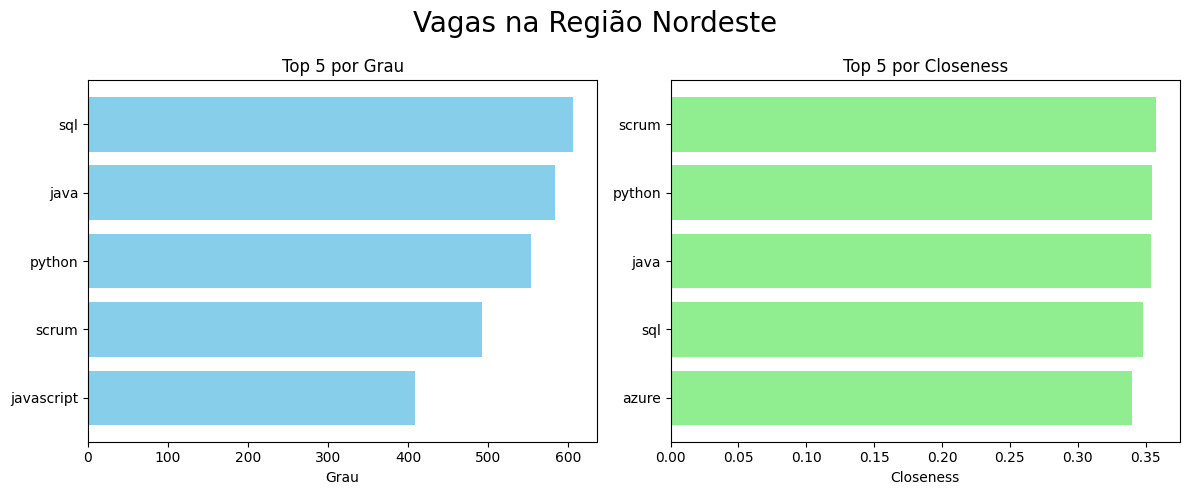

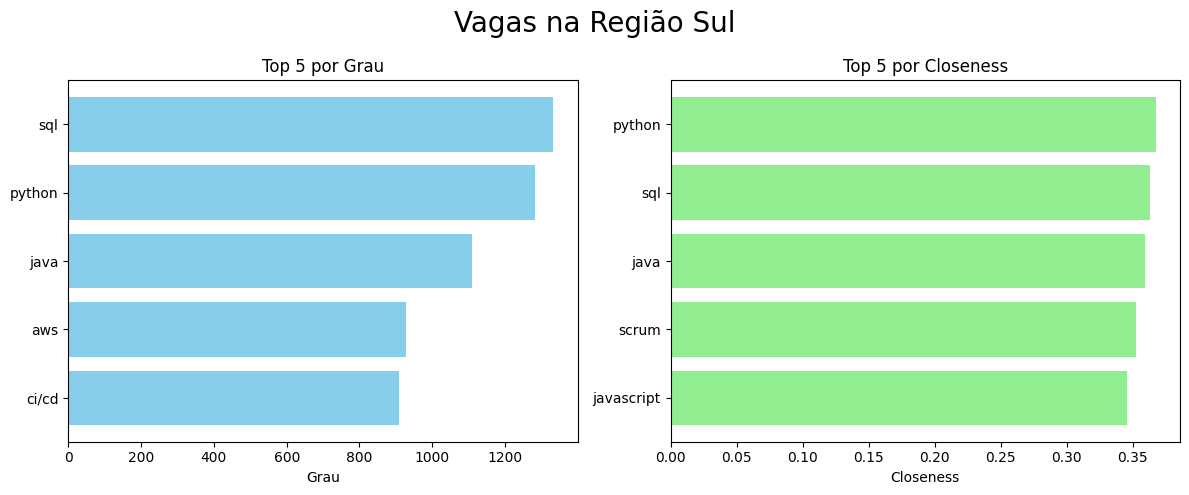

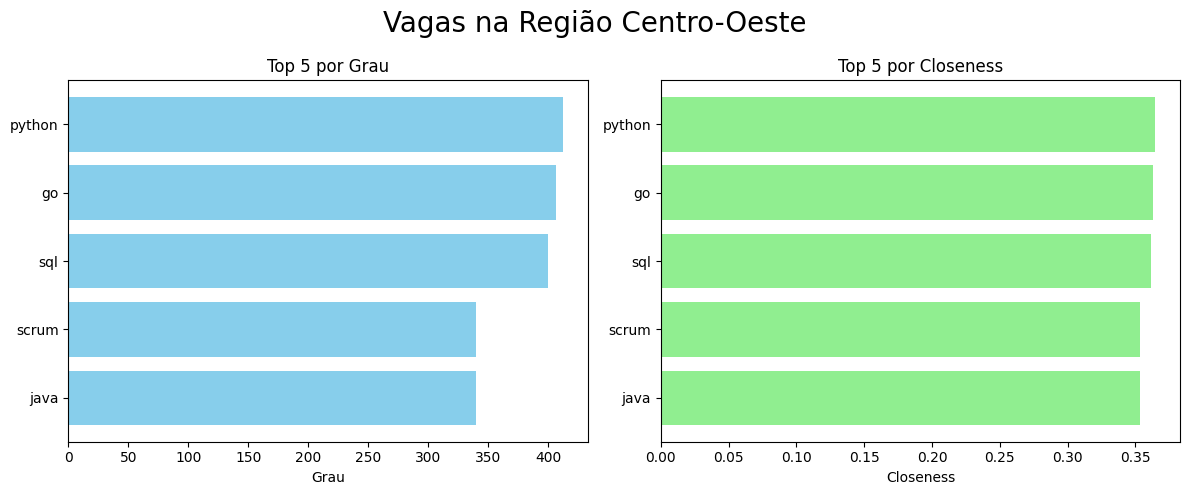

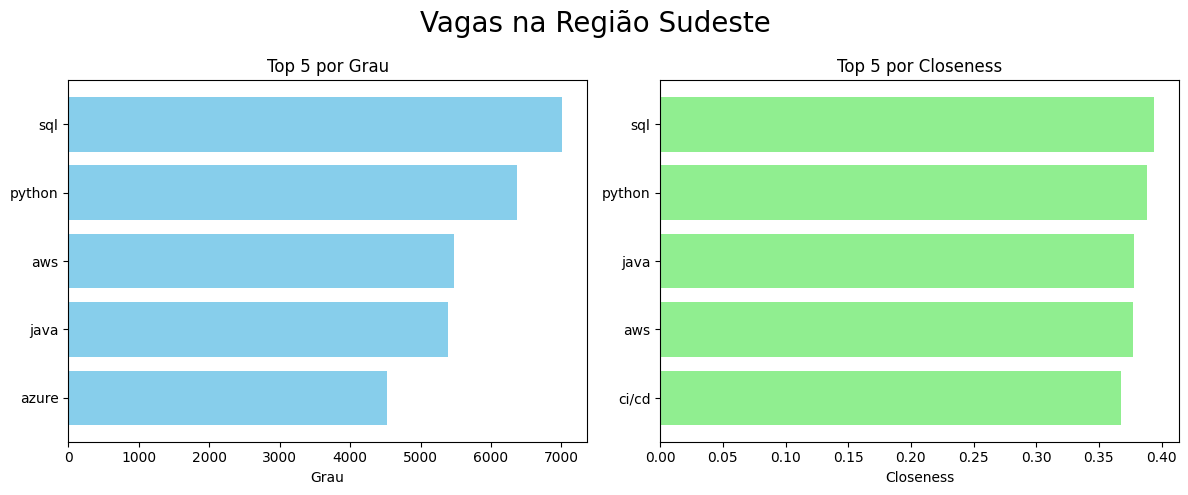

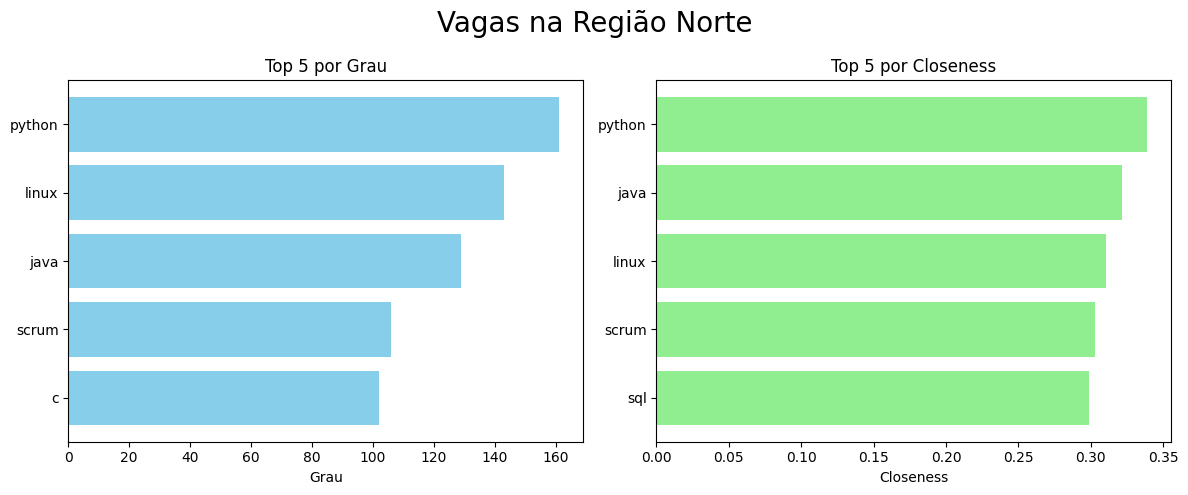

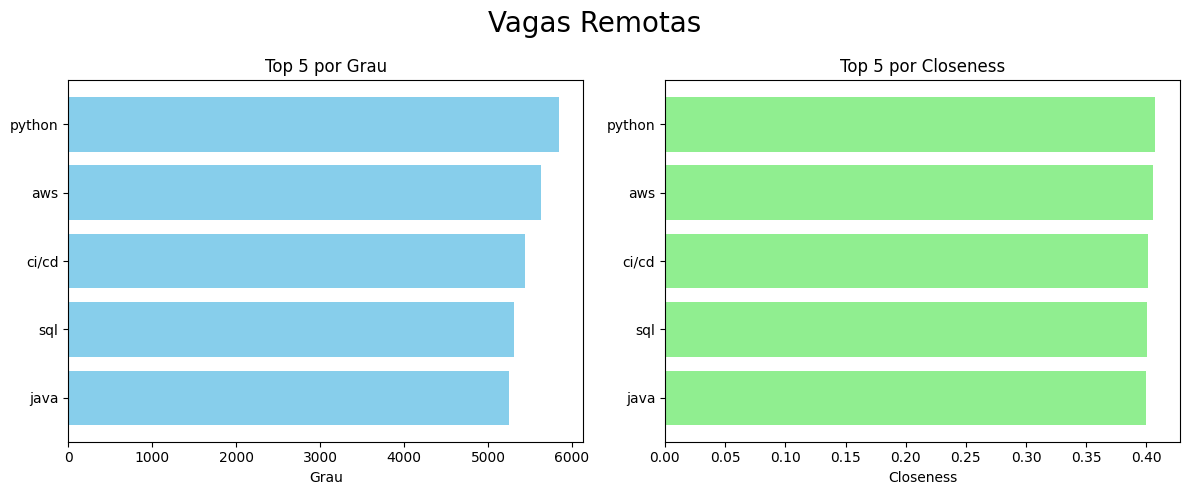

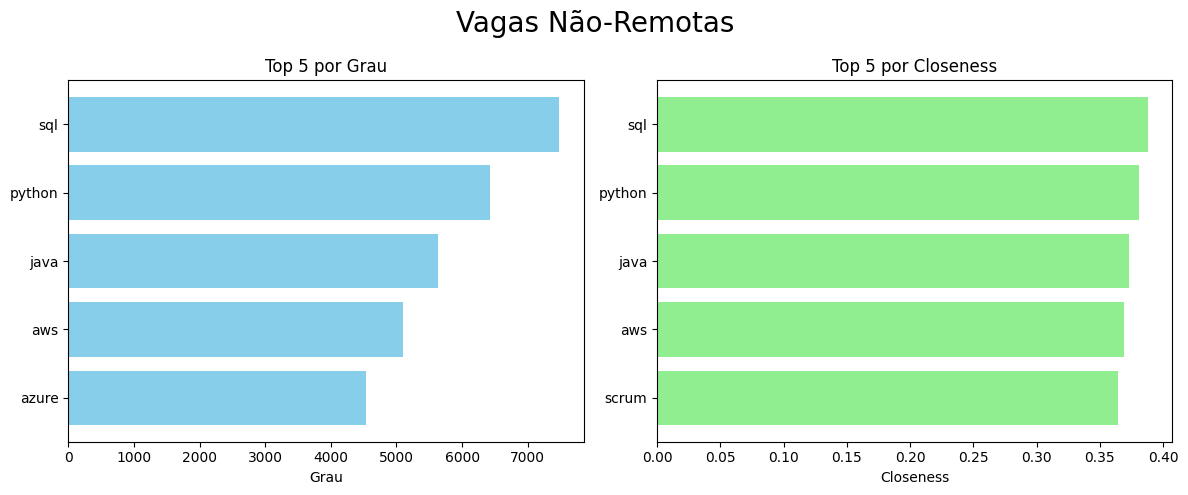

In [11]:
fig_titles = {
    "location_North": "Vagas na Região Norte",
    "location_Northeast": "Vagas na Região Nordeste",
    "location_Central-West": "Vagas na Região Centro-Oeste",
    "location_Southeast": "Vagas na Região Sudeste",
    "location_South": "Vagas na Região Sul",
    "remote_True": "Vagas Remotas",
    "remote_False": "Vagas Não-Remotas",
}

# Criando uma visualização simples para cada métrica, mostrando o top 5 de cada subgrafo
for key, df in subgraph_metrics.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(fig_titles[key], fontsize=20)

    # Top 5 por grau
    df = df.sort_values("degree", ascending=False).reset_index(drop=True)
    axes[0].barh(df["skill"].head(5), df["degree"].head(5), color="skyblue")
    axes[0].set_title("Top 5 por Grau")
    axes[0].set_xlabel("Grau")
    axes[0].invert_yaxis()

    # Top 5 por closeness
    df = df.sort_values("closeness", ascending=False).reset_index(drop=True)
    axes[1].barh(df["skill"].head(5), df["closeness"].head(5), color="lightgreen")
    axes[1].set_title("Top 5 por Closeness")
    axes[1].set_xlabel("Closeness")
    axes[1].invert_yaxis()

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f"images/{key}_metrics.png", dpi=300, bbox_inches="tight")
    plt.show()